In [1]:
import pandas as pd
import json
import numpy as np
import time
import datetime
from scipy.sparse import csr_matrix
import scipy.stats as stats
from sklearn.metrics.pairwise import pairwise_distances
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path
import re

# Постановка задачи

**Задача**

Необходимо построить векторное представление музыкантов так, чтобы наиболее похожие музыка оказались в пространстве признаков как можно ближе друг к другу

**Имеющиеся данные**
1. Данные о пользователях
2. Данные о музыкантах
3. Данные о музыкальных композициях
4. Данные о альбомах
5. Данные о плейлистах пользователей

**Выдвижение гипотезы**

Т.к. в нашем датасете нет информации о реальной "схожести" исполнителей, то для того, чтобы искать эту "схожесть" необходимо поставить гипотезу.

Гипотеза - пользователи в общей своей массе слушают похожих друг на друга исполнителей.\
Придерживаясь данной гипотезы мы можем перейти к задаче рекомендации похожих исполнителей пользователям

**Способ решения задачи**

Задачу поиска похожих исполнителей можно свести к задаче создания content-based рекомендательной системы\
Будем рекомендовать пользователю исполнителей, похожих на тех исполнителей, которых пользователь уже послушал

**Оценка работы моделей**

В нашем датасете отсутствует информация о том, какую оценку пользователь поставил треку, у нас имеются лишь данные о том, какие треки пользователь прослушал.

Таким образом, у нас имеется implicit feedback, но не explicit feedback.

То есть, если пользователь прослушал исполнителя i, но не прослушал исполнителя j, то это не значит, что ему нравится исполнитель i и не нравится исполнитель j, вполне возможно, что пользователь просто не знает про существование исполнителя j.\
Поэтому нам не подходят такие метрики оценивания как MAE, RMSE(например предсказывать, сколько раз пользователь будет слушать треки исполнителя i), которые часто используются в explicit feedback моделях для предсказания оценки, потому что у нас банально нет оценок, а также нет адекватной альтернативы, которую можно использовать в качестве оценки. Можно было бы использовать использовать в качестве target variable, например, время прослушивания треков артиста, или количество прослушиваний треков артиста пользвоателем, но в таком случае точность для каждого пользователя будет сильно зависеть от того, как часто пользователь слушает треки (например, для пользователя, часто прослушивающего треки, будет выгодно предсказывать большее количество треков/времени их прослушивания), в то время как пользователю, редко слушающему музыку, выгодно предсказать, что он вовсе ничего не прослушает. Однако, такие результаты не будут отражать реальную точность результатов

Вместо этого я предлагаю использовать метрики, основанные на ранжировании музыкантов по "вероятности" того, что пользователь прослушает треки данного исполнителя. При этом измерять точность модели я буду на основании того, на каком месте в ранжированном списке исполнителей находятся исполнители, которых пользователь в действительности послушал. Такой способ оценки позволит оценить релевантность рекомендаций вне зависимости от того, как много и как часто пользователь слушает музыку. Чем "ближе" исполнители, которых слушает пользователь, к топу ранжированного списка, тем релевантнее рекомендация.

**Алгоритм решения задачи**
1. Построить векторное представление исполнителей
2. Посчитать расстояние между всеми исполнителями.
3. Выбрать информацию о расстоянии между исполнителями, которых прослушал пользователь, и всеми остальными исполнителями
4. Для всех исполнителей посчитать среднее расстояние от них до исполнителей, которых уже послушал пользователь
5. Отранжировать исполнителей в порядке возрастания среднего расстояния до уже прослушанных исполнителей
6. Посчитать метрику работы модели - среднее относительное место(кванитиль) исполнителей, которых прослушал пользователь, в ранжированном списке исполнителей. Следовательно, чем меньшее среднее место (квантиль) - тем лучше модель рекомендует пользователю исполнителей

При этом вместо абсолютного среднего места будет использоваться именно относительное (то есть среднее место разделить на длину ранжированного списка), т.к. при использовании разных данных(о плейлистах/сессиях/всех прослушиваниях) длины ранжированного списка получались разные (потому что в разных датасетах есть информация о разных исполнителях, не о всех сразу).



При этом метрики расстояния я буду использовать разные, а не только евклидову метрику расстояния

# Загрузка данных

## Список исполнителей

1. MBID
2. Name

In [ ]:
person_data = pd.read_csv('entities\\persons.idomaar', sep = '\t', names = ['person', 'person_id', 'timestamp', 'json_data', 'delete'])

In [ ]:
person_data['json_data'] = person_data['json_data'].apply(json.loads)

In [ ]:
person_data['MBID'] = person_data['json_data'].apply(lambda x: x['MBID'])
person_data['artist_name'] = person_data['json_data'].apply(lambda x: x['name'])

In [ ]:
print(person_data['person'].unique())
print(person_data['timestamp'].unique())

In [ ]:
person_data = person_data.drop(['person', 'timestamp', 'json_data', 'delete'], axis = 'columns')

In [ ]:
person_data.head()

In [ ]:
person_data.to_csv('persons.csv', index = False)

## Список треков

1. Длительность трека
2. Сколько раз прослушали трек
3. MBID
4. Название
5. Артист
6. Альбом
7. Тэги

In [ ]:
tracks_data = pd.read_csv('entities\\tracks.idomaar', sep = '\t', names = ['track', 'track_id',  'timestamp', 'json_data', 'linked_data'])

In [ ]:
tracks_data['json_data'] = tracks_data['json_data'].apply(json.loads)

In [ ]:
tracks_data['duration'] = tracks_data['json_data'].apply(lambda x: x['duration'])
tracks_data['playcount'] = tracks_data['json_data'].apply(lambda x: x['playcount'])
tracks_data['MBID'] = tracks_data['json_data'].apply(lambda x: x['MBID'])
tracks_data['name'] = tracks_data['json_data'].apply(lambda x: x['name'])

In [ ]:
tracks_data['linked_data'] = tracks_data['linked_data'].apply(json.loads)

In [ ]:
tracks_data['artist_id'] = tracks_data['linked_data'].apply(lambda x: x['artists'][0]['id'])
tracks_data['albums'] = tracks_data['linked_data'].apply(lambda x: x['albums'])
tracks_data['tags'] = tracks_data['linked_data'].apply(lambda x: x['tags'])

In [ ]:
tracks_data = tracks_data.drop(['track', 'timestamp', 'json_data', 'linked_data'], axis = 'columns')

In [ ]:
tracks_data.head()

In [ ]:
tracks_data.to_csv('tracks.csv', index = False)

## Плейлисты

In [ ]:
playlist_data = pd.read_csv('entities\\playlist.idomaar', sep = '\t', names = ['playlist', 'playlist_id', 'timestamp', 'json_data', 'playlist_tracks'])

In [ ]:
playlist_data['json_data'] = playlist_data['json_data'].apply(lambda x: re.sub('\"Title\":.*?,(?=\"numtracks\")', '', x))
playlist_data['json_data'] = playlist_data['json_data'].apply(json.loads)

In [ ]:
playlist_data['numtracks'] = playlist_data['json_data'].apply(lambda x: x['numtracks'])
playlist_data['duration'] = playlist_data['json_data'].apply(lambda x: x['duration'])

In [ ]:
playlist_data['playlist_tracks'] = playlist_data['playlist_tracks'].apply(json.loads)

In [ ]:
playlist_data['user_id'] = playlist_data['playlist_tracks'].apply(lambda x: x['subjects'][0]['id'])

In [ ]:
playlist_data['playlist_tracks'] = playlist_data['playlist_tracks'].apply(lambda x: x['objects'])
playlist_data = playlist_data[playlist_data['playlist_tracks'].astype(str) != '[[]]'].reset_index(drop = True)
playlist_data = playlist_data[playlist_data['numtracks']!= 0].reset_index(drop = True)

In [ ]:
playlist_data['playlist_tracks'] = playlist_data['playlist_tracks'].apply(lambda x: list(map(lambda y: y['id'], x)))

In [ ]:
playlist_data = playlist_data.explode('playlist_tracks')
playlist_data = playlist_data.rename(columns = {'playlist_tracks' : 'track_id'})

In [ ]:
playlist_data = playlist_data.drop(['playlist', 'json_data'], axis = 'columns')

In [ ]:
playlist_data.head()

In [ ]:
playlist_data.to_csv('playlists.csv', index = False)

## Список прослушиваний

1. Play time
2. Пользователь
3. Трек

In [ ]:
event_data = pd.read_csv('relations\\events.idomaar', sep = '\t', names = ['event_type', 'event_id',  'timestamp', 'playtime', 'json_data'])

In [ ]:
event_data['json_data'] = event_data['json_data'].apply(json.loads)

In [ ]:
event_data['user_id'] = event_data['json_data'].apply(lambda x: x['subjects'][0]['id'])
event_data['track_id'] = event_data['json_data'].apply(lambda x: x['objects'][0]['id'])

In [ ]:
event_data['playtime'] = event_data['playtime'].apply(lambda x: json.loads(x)['playtime'])

In [ ]:
event_data = event_data.drop(['event_type', 'json_data'], axis = 'columns')

In [ ]:
event_data.head()

In [ ]:
event_data.to_csv('events.csv', index = False)

## Список сессий

In [ ]:
session_data = pd.read_csv('relations\\sessions.idomaar', sep = '\t', names = ['event.session', 'session_id', 'timestamp', 'json_data'])

In [ ]:
session_data = pd.concat([session_data, session_data['json_data'].str.split(' ', expand = True).rename(columns = {0 : 'session_data', 1: 'session_tracks'})], axis = 'columns')

In [ ]:
session_data['session_data'] = session_data['session_data'].apply(json.loads)

In [ ]:
session_data['numtracks'] = session_data['session_data'].apply(lambda x: x['numtracks'])
session_data['playtime'] = session_data['session_data'].apply(lambda x: x['playtime'])

In [ ]:
session_data['session_tracks'] = session_data['session_tracks'].apply(json.loads)

In [ ]:
session_data['user_id'] = session_data['session_tracks'].apply(lambda x: x['subjects'][0]['id'])
session_data['session_tracks'] = session_data['session_tracks'].apply(lambda x: x['objects'])

In [ ]:
session_data = session_data.explode('session_tracks')

In [ ]:
session_data['action_type'] = session_data['session_tracks'].apply(lambda x: x['action'])
session_data['track_id'] = session_data['session_tracks'].apply(lambda x: x['id'])
session_data['playstart'] = session_data['session_tracks'].apply(lambda x: x['playstart'])
session_data['playtime'] = session_data['session_tracks'].apply(lambda x: x['playtime'])
session_data['playratio'] = session_data['session_tracks'].apply(lambda x: x['playratio'])

In [ ]:
session_data = session_data.drop(['event.session', 'json_data', 'session_data', 'session_tracks'], axis = 'columns')

In [ ]:
session_data.head()

In [ ]:
session_data.to_csv('sessions.csv', index = False)

# Обзор и чистка данных

## Tracks

In [2]:
track_data = pd.read_csv('tracks.csv')

C:\Users\Sibmice\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Проверим данные на наличие дубликатов

In [3]:
duplicated_rows = track_data.duplicated(['track_id', 'artist_id'])
duplicated_rows = duplicated_rows[duplicated_rows == True]

In [4]:
duplicated_tracks = track_data.loc[duplicated_rows.index, :]['track_id'].values
duplicated_artists = track_data.loc[duplicated_rows.index, :]['artist_id'].values

In [5]:
len(duplicated_rows)

1155824

Таким образом, всего в данных о треках есть 1155824 дубликатов. Рассмотрим их подробнее

In [6]:
track_data[(track_data['track_id'].isin(duplicated_tracks)) & (track_data['artist_id'].isin(duplicated_artists))].sort_values('artist_id')

,track_id,duration,playcount,MBID,name,artist_id,albums,tags
4885799,4657016,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,53,NaN,NaN
4885737,4657016,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,53,NaN,NaN
5417463,4928006,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,60,NaN,NaN
5417462,4928006,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,60,NaN,NaN
170,170,212000.0,2.0,d6b90442-b413-456c-8e3d-8a5eb6b5854f,All+Saints/_/Chick+Fit,78,"[{'type': 'album', 'id': 6}]","[{'type': 'tag', 'id': 189631}, {'type': 'tag'..."
...,...,...,...,...,...,...,...,...
5674911,5023034,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595120,NaN,NaN
5674937,5023042,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595121,NaN,NaN
5674935,5023042,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595121,NaN,NaN
5675004,5023053,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595123,NaN,NaN


Удалим все дубликаты в парах (track_id - artist_id)

In [7]:
track_data = track_data[(track_data['track_id'].isin(duplicated_tracks) == False) & (track_data['artist_id'].isin(duplicated_artists) == False)]

In [8]:
track_data = track_data.reset_index(drop = True)

Теперь рассмотрим повторяющиеся треки

In [9]:
duplicated_tracks = track_data.duplicated('track_id')
duplicated_tracks = duplicated_tracks[duplicated_tracks == True]
duplicated_tracks = track_data.loc[duplicated_tracks.index, :]['track_id'].values

In [10]:
duplicated_rows = track_data[track_data['track_id'].isin(duplicated_tracks)].sort_values('track_id')

In [11]:
duplicated_rows

,track_id,duration,playcount,MBID,name,artist_id,albums,tags
32669,79890,-1.0,1617.0,NaN,Adventures+Of+Stevie+V/_/Dirty+Cash+-+Radio+Edit,468413,[],[]
1051326,79890,-1.0,1617.0,NaN,Adventures+Of+Stevie+V/_/Dirty+Cash+-+Radio+Edit,11173,[],[]
588658,1338834,-1.0,264.0,NaN,GoGoGo+Airheart/_/A+New+House,168790,[],[]
588659,1338834,-1.0,264.0,NaN,GoGoGo+Airheart/_/A+New+House,168789,[],[]
1305029,3353773,448000.0,1.0,NaN,De%C5%BEo+Ursiny/_/Harakiri,416503,"[{'type': 'album', 'id': None}]","[{'type': 'tag', 'id': 123430}]"
1305044,3353773,448000.0,1054.0,NaN,De%C5%BEo+Ursiny/_/Harakiri,416502,"[{'type': 'album', 'id': None}]","[{'type': 'tag', 'id': 123430}]"
1305030,3353774,-1.0,846.0,NaN,De%C5%BEo+Ursiny/_/Hovor+mi+do+ucha,416503,[],[]
1305045,3353774,-1.0,846.0,NaN,De%C5%BEo+Ursiny/_/Hovor+mi+do+ucha,416502,[],[]
1305031,3353775,-1.0,9.0,NaN,"De%C5%BEo+Ursiny/_/Nie%C3%A8o+pre+zasmiatie,+n...",416503,[],[]
1305054,3353775,-1.0,9.0,NaN,"De%C5%BEo+Ursiny/_/Nie%C3%A8o+pre+zasmiatie,+n...",416502,[],[]


Подробнее рассмотрим данных исполнителей

In [12]:
person_data = pd.read_csv('persons.csv')

In [13]:
person_data[person_data['person_id'].isin(duplicated_rows['artist_id'].values)]

,person_id,MBID,artist_name
6306,468413,6500ea06-c13b-4bbe-8a48-65c2fddfdc21,Adventures+Of+Stevie+V
104842,168789,NaN,GoGoGo+Airheart+Band
355932,11173,NaN,The+Adventures+Of+Stevie+V
418681,168790,363119f7-1321-41f7-8186-a9674318ab70,GoGoGo+Airheart
447916,416502,87e4ff1b-fdcb-49a9-8886-525e5da6a61d,De%C5%BEo+Ursiny
519200,416503,NaN,De%C2%9Eo+Ursiny


На самом деле исполнители с разными id одни и те же исполнители, у которых просто немного отличаются названия групп/имена исполнителей. Adventures+Of+Stevie+V тоже самое, что и The+Adventures+Of+Stevie+V. Объединим в нашем датасете этих исполнителей.

In [14]:
track_data['artist_id'] = track_data['artist_id'].replace({468413: 11173, 168789: 168790, 416502: 416503})

Рассмотрим частоту встречаемости названий треков

In [15]:
track_data['name'].value_counts()

ZZ+Top/_/She+Loves+My+Automobile                        171135
De%C5%BEo+Ursiny/_/Predposledn%C3%A1+ve%C3%A8era             2
De%C5%BEo+Ursiny/_/Ten+ist%C3%BD+tanec                       2
GoGoGo+Airheart/_/A+New+House                                2
Adventures+Of+Stevie+V/_/Dirty+Cash+-+Radio+Edit             2
                                                         ...  
Steriogram/_/Sing+the+Night+Away                             1
Juaninacka/_/Pod%C3%A9is+llamarlo+respeto+(con+Zatu)         1
White+Trees/_/White                                          1
The+Golden+Hippie/_/Human+Animal                             1
Dan+Warren/_/16+-+Fuck+you                                   1
Name: name, Length: 1538980, dtype: int64

Треки с названием ZZ+Top/_/She+Loves+My+Automobile  встречаются слишком часто. Рассмотрим их подробнее

In [16]:
track_data[track_data['name'] == 'ZZ+Top/_/She+Loves+My+Automobile']

,track_id,duration,playcount,MBID,name,artist_id,albums,tags
1538989,4397331,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,508184,NaN,NaN
1538990,4397333,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,224835,NaN,NaN
1538991,4397360,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,440240,NaN,NaN
1538992,4397361,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,440240,NaN,NaN
1538993,4397362,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,440240,NaN,NaN
...,...,...,...,...,...,...,...,...
1710119,5023098,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595137,NaN,NaN
1710120,5023099,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595138,NaN,NaN
1710121,5023102,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,232357,NaN,NaN
1710122,5023104,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595139,NaN,NaN


Рассмотрим несколько исполнителей из датасета выше

In [17]:
person_data[person_data['person_id'].isin([508184, 224835, 440240, 595138, 595139])]

,person_id,MBID,artist_name
37556,224835,e08dff00-e971-48f0-8ffe-8d07b4297c94,MC+Fitti
188170,595138,NaN,"Tam+Cooper,+Will+Saul"
196200,508184,NaN,R.A.+The+Rugged+Man+(feat.+Masta+Killa+&+Killa...
537593,440240,9f01b9ea-162d-47f5-93b1-3f6a3aeb4b24,Immaculate+Machine
592213,595139,NaN,Cousin+Silas+&+LPF12


Исполнители действительно разные, но названия треков одинаковые. Скорее всего это просто ошибочные названия треков

Удалим появившиесся дубликаты в паррах track_id - artist_id

In [18]:
track_data = track_data.drop_duplicates(['track_id', 'artist_id'])

Рассмотрим пропущенные значения в колонке duration

In [19]:
track_data[(track_data['duration'].isna()) | (track_data['duration'] == -1)]

,track_id,duration,playcount,MBID,name,artist_id,albums,tags
0,0,-1.0,4.0,NaN,000003+Music+Instructor/_/Dj%27s+Rock+Da+House...,0,[],[]
1,1,-1.0,495.0,NaN,00-01/_/%D0%A2%D0%B5%D0%BA%D1%81%D1%82,1,[],[]
2,2,-1.0,2.0,NaN,0005.+Overkill/_/Overkill,2,[],[]
3,3,-1.0,2.0,NaN,000C+Tony+Dize/_/Ruleta+Rusa,3,[],[]
4,4,-1.0,1.0,NaN,000+Oscarcito/_/Tumbay%E2%80%9A+(Lyrics),4,[],[]
...,...,...,...,...,...,...,...,...
1710119,5023098,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595137,NaN,NaN
1710120,5023099,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595138,NaN,NaN
1710121,5023102,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,232357,NaN,NaN
1710122,5023104,NaN,NaN,NaN,ZZ+Top/_/She+Loves+My+Automobile,595139,NaN,NaN


В большинстве треков пропущены данные о длительности, так что я не буду использовать эту переменную

Сохраним отфильтрованный датасет

In [ ]:
track_data.to_csv('tracks_modified.csv', index = False)

## Events

In [20]:
event_data = pd.read_csv('events.csv')

Рассмотрим информацию о дате прослушивания

In [21]:
dates = event_data['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

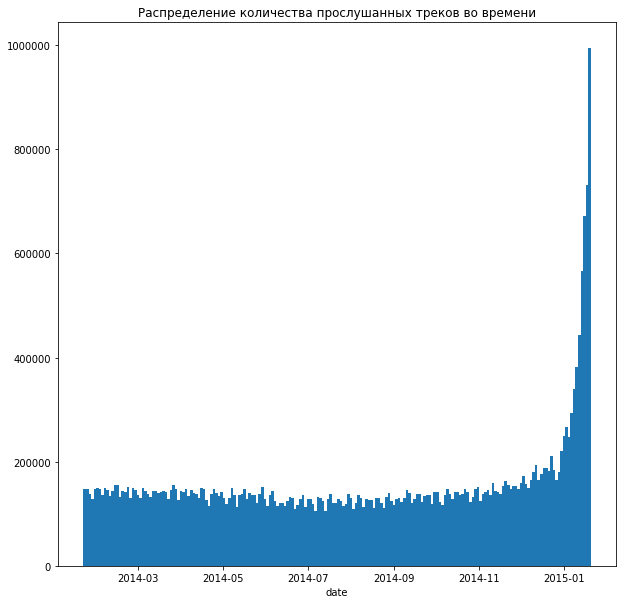

In [22]:
_ = plt.figure(figsize = (10, 10))
_ = plt.title('Распределение количества прослушанных треков во времени')
_ = dates.hist(bins = 200, grid = False)
_ = plt.xlabel('date')

Распределение равномерное, с выбросом ближе к концу выборки. Будем учитывать это при оценке работы моделей (будем стараться избегать конца выборки, т.к. там данные не следуют общей тенденции)

Рассмотрим информацию о времени прослушивания

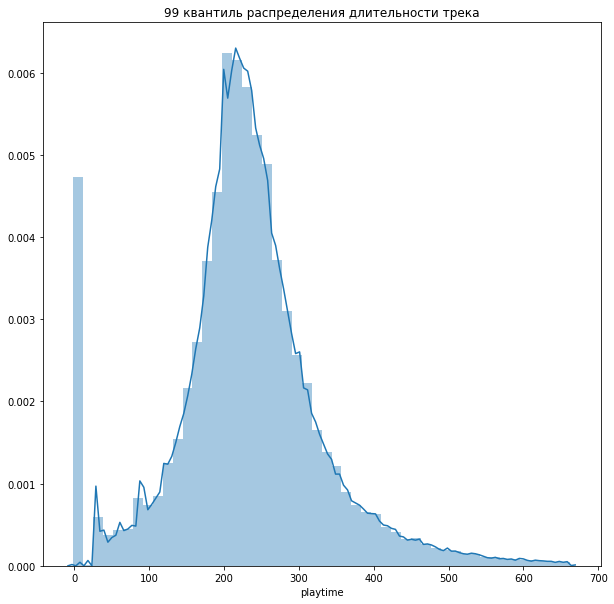

In [23]:
_ = plt.figure(figsize = (10,10))
_ = plt.title('99 квантиль распределения длительности трека')
_ = sns.distplot(event_data[event_data['playtime']<np.quantile(event_data['playtime'], 0.99)]['playtime'])

Распределение прослушивания треков выглядит как нормальное, однако присутствует длинный хвост справа\
Также в левой части распределения наблюдается выброс. Рассмотрим его подробнее

In [24]:
event_data['playtime'].value_counts()

-1       1277893
 0        663917
 200      273645
 216      207879
 224      206795
          ...   
 7503          1
 7492          1
 5255          1
 7485          1
 6936          1
Name: playtime, Length: 8594, dtype: int64

У большого количества треков длительность прослушивания 0 или -1. Удалим наблюдения, в которых длительность прослушивания менее 10 секунд, т.к. можно предположить, что польователь просто скипал эти треки

In [25]:
event_data = event_data[event_data['playtime']>=10]

Сохраним отфильтрованные данные

In [ ]:
event_data.to_csv('events_modified.csv', index = False)

## Sessions

In [26]:
session_data = pd.read_csv('sessions.csv')

Рассмотрим тип действия во время сессии

In [27]:
session_data['action_type'].value_counts(dropna = False)

play    26993356
NaN      2908889
skip     1449700
Name: action_type, dtype: int64

In [28]:
session_data[session_data['action_type'] == 'skip']['playtime'].sort_values()

115          0
13172798     0
13172797     0
13172796     0
23750073     0
            ..
1956820     10
18399369    10
234292      10
6946080     10
8879573     10
Name: playtime, Length: 1449700, dtype: int64

Удалим из сессий те треки, которые пользователь скипнул

In [29]:
session_data = session_data[session_data['action_type'] != 'skip']

In [30]:
session_data[session_data['action_type'].isna()]['playtime'].sort_values()

22         -1
20916513   -1
20916518   -1
20916523   -1
20916525   -1
           ..
10484739   -1
10484741   -1
10484746   -1
10484923   -1
31351944   -1
Name: playtime, Length: 2908889, dtype: int64

Если нет информации о типе действия, то нет и информации о длителньости прослушивания трека. Также удалим такие наблюдения

In [31]:
session_data = session_data[session_data['action_type'].isna() == False]

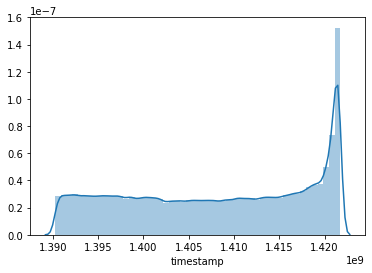

In [32]:
sns.distplot(session_data['timestamp'])

Распределение времени сессий такое же, как и у времени прослушивания треков

Сохраним полученный датасет

In [ ]:
session_data.to_csv('sessions_modified.csv', index = False)

# Валидация моделей

Общий алгоритм оценки работы моделей:

1. Разбить данные по времени на 2 подвыборки - train и test (длительность test period = 60 дней, начало тестового периода: 07/10/2014)
2. Выбрать тех пользователей, у которых есть оценка в обоих подвыборках
3. Рандомно выбрать из них 100 пользователей
4. Для каждого пользователя считать метрику близости между исполнителями, которых прослушал пользователь, и всеми остальными исполнителями
5. Сортировать артистов по возрастанию среднего метрики близости от уже прослушанных исполнителей
6. Считать среднее относительное место исполнителей, которых прослушал пользователь во время test периода. Меньше место - лучше результат модели

In [37]:
## Функция подсчета количества треков исполнителя для каждого пользователя/плейлиста/сессии
def count_agg(event_data, track_data, second_var, agg_col, fun):
    merged_data = event_data.merge(track_data, on = 'track_id')
    user_artist_count = merged_data.groupby([second_var, 'artist_id']).agg({agg_col : fun}).rename(columns = {agg_col : 'stat'}).reset_index()
    
    return(user_artist_count)

In [38]:
## Добавление индексов для исполнителя и второй переменной (пользователь, сессия, плейлист и т.д.)
def add_idx(data, second_var):
    indexes_user = pd.DataFrame({
        '{}'.format(second_var) : data[second_var].unique(),
        '{}_matrix'.format(second_var) : list(range(0, len(data[second_var].unique())))
    }
    )
    indexes_artist = pd.DataFrame({
        'artist_id' : data['artist_id'].unique(),
        'artist_id_matrix' : list(range(0, len(data['artist_id'].unique())))
    }
    )
    data = data.merge(indexes_user).merge(indexes_artist)
    return data

In [39]:
## Разбиваем на train и test по времени и выбираем пользователей, для которых будем рекомендовать исполнителей
def traintest_split(event_data, test_start = 1405000000, test_period = 5184000):
    train_events = event_data[event_data['timestamp'] <= test_start]
    test_events = event_data[(event_data['timestamp'] > test_start) & (event_data['timestamp'] < (test_start+test_period))]
        
    return (train_events, test_events)

In [40]:
## Разбиваем на train и test по времени и выбираем пользователей, для которых будет рекомендовать исполнителей
def select_users(event_data, test_start = 1405000000, test_period = 5184000, num_users = 100, seed = 599_000):
    train_events = event_data[event_data['timestamp'] <= test_start]
    train_events = count_agg(train_events, track_data, 'user_id', 'event_id', 'count')
    
    test_events = event_data[(event_data['timestamp'] > test_start) & (event_data['timestamp'] < (test_start+test_period))]
    test_events = count_agg(test_events, track_data, 'user_id', 'event_id', 'count')
    
    train_users = train_events[train_events['stat'] > 5]['user_id'].values
    test_users = test_events[train_events['stat'] > 5]['user_id'].values
    
    aval_users = np.intersect1d(train_users, test_users)
    np.random.seed(seed)
    sampled_users = np.random.choice(aval_users, num_users)
    
        
    return(sampled_users)

In [41]:
## Создание матрицы исполнители - пользователи/сессии/плейлисты и тд.
def creating_matrix(data, col_data, value):
    col = data[col_data].values
    row = data['artist_id_matrix'].values
    data = data[value].values
    matrix = csr_matrix((data, (row, col)))
    return matrix

In [42]:
## Выбрать исполнителей, похожих на исполнителей, которых пользователь уже слушал, на основе матрицы train_matrix
def predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, metric, inverse = False, verbose = True):
    global similarities
    all_metrics = []
    num_train_artists = []
    num_test_artists = []
    
    for user in sampled_users: ## Для каждого пользователя
        start = time.time()
        
        ## Выбираем информацию о прослушиваниях исполнителей для конкретного пользователя для тренировочного и тестового периодов
        user_train_data = train_data[train_data['user_id'] == user]
        user_train_artists = user_train_data['artist_id'].values
        user_test_data = test_data[test_data['user_id'] == user]
        user_test_artists = user_test_data['artist_id'].values
        
        ## Переводим id исполнителей в номера строк матрицы информации об исполнителях
        user_train_artists = matrix_id[matrix_id['artist_id'].isin(user_train_artists)]['artist_id_matrix'].unique()
        user_test_artists = matrix_id[matrix_id['artist_id'].isin(user_test_artists)]['artist_id_matrix'].unique()
        
        ## Создаем пустой векторр схожести исполнителей
        user_similarity_matrix = np.empty(shape = (train_matrix.shape[0], 1))
        
        ## Для каждого исполнителя из списка исполнителей, которых прослушал пользователь во время train периода
        for artist in user_train_artists:
            
            ## Считаем схожесть между исполнителем и всеми остальными исполнителями из матрицы информации об исполнителях
            artist_similarity = pairwise_distances(train_matrix, train_matrix[artist, :], metric = metric)
            
            ## Развернуть ли метрику схожести или нет (например с евклидовой метрикой - больше расстояние, разворачиваем, значением метрики становится меньше)
            if inverse == True:
                artist_similarity = 1/(1+artist_similarity)
            
            ## Добавляем столбец схожестимежду исполнителем и всеми остальными исполнителями
            user_similarity_matrix = np.concatenate((user_similarity_matrix, artist_similarity), axis = 1)
        
        ## Считаем среднюю схожесть между тренировочными исполнителями и всеми остальными
        similarities = np.mean(user_similarity_matrix, axis = 1)
        
        ## Сортируем индексы строк по убыванию значения в этой строке в порядке возрастания (то есть от самых похожих к самым непохожим исполнителям)
        similarities = np.argsort(similarities)  ### argsort по умолчанию сортирует в порядке возрастания 
        
        ## Считаем средний индекс (то есть среднюю позицию в ранжированном списке) исполнителей из тестового периода, которых прослушал пользователь
        positions = np.isin(similarities, user_test_artists)
        positions = np.where(positions == True)
        result = np.mean(positions[0])/len(similarities)
        
        ## Добавляем информацию о метрике и количестве исполнителей в тренировочном и тестовом датасете
        all_metrics.append(result)
        num_train_artists.append(len(user_train_artists))
        num_test_artists.append(len(user_test_artists))  
            
        if verbose:
            print('Metric: {}, Number of train artists: {},Number of test artists: {}, Train time: {}'.format(result, len(user_train_artists), len(user_test_artists), time.time()-start))
    return(all_metrics, sampled_users, num_train_artists, num_test_artists)

In [43]:
## Добавить результаты в csv файл
def add_results(all_metrics, sampled_users, num_train_artist, num_test_artists, model_name):
    data = pd.DataFrame(np.array([all_metrics, sampled_users, num_train_artist, num_test_artists]).T, columns = pd.MultiIndex.from_product([[model_name], ['scores', 'user', 'num_train_artist', 'num_test_artists']]))
    if path.exists('results.csv'):
        results_loaded = pd.read_csv('results.csv', header=[0,1])
        data = pd.concat([results_loaded, data], axis = 'columns')
        
    data.to_csv('results.csv', index = False)

# Baseline model

В бейзлайн модели будем сравнивать исполнителей на основе количества их треков

In [44]:
track_data = pd.read_csv('tracks_modified.csv')
event_data = pd.read_csv('events_modified.csv')

In [45]:
similarities = track_data['artist_id'].value_counts().sort_values(ascending = False).index

In [46]:
train_events, test_events = traintest_split(event_data)
test_events = test_events.merge(track_data, on = 'track_id')
sampled_users = select_users(event_data)

C:\Users\Sibmice\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [47]:
all_results = []
for user in sampled_users:
    user_test_data = test_events[test_events['user_id'] == user]
    user_test_artists = user_test_data['artist_id'].unique()
    
    positions = np.isin(similarities, user_test_artists)
    positions = np.where(positions == True)
    result = np.mean(positions[0])/len(similarities)
    all_results.append(result)

In [48]:
print('Model result:' , np.mean(all_results))

Model result: 0.17927023989327978


In [ ]:
pd.DataFrame({'baseline_results' : all_results}).to_csv('baseline_results.csv', index = False)

Таким образом, результат baseline модели - 0.179, то есть в среднем, прослушанные во время тестового периода исполнители находятся в топ 17% ранжированного списка

# Advanced models

В advanced моделях будем использовать информацию о прослушиваниях треков артистов из различных датасетов (прослушивания, плейлисты, сессии)

## Events

In [ ]:
event_data = pd.read_csv('events_modified.csv')
track_data = pd.read_csv('tracks_modified.csv')

In [ ]:
train_events, test_events = traintest_split(event_data)
sampled_users = select_users(event_data)

In [ ]:
train_data = count_agg(train_events, track_data, 'user_id', 'playtime', 'sum') 
train_data = add_idx(train_data, 'user_id')

test_data = count_agg(test_events, track_data, 'user_id', 'playtime', 'sum')
test_data = add_idx(test_data, 'user_id')

train_matrix = creating_matrix(train_data, 'user_id_matrix', 'stat')

In [ ]:
matrix_id = train_data[['artist_id', 'artist_id_matrix']]

In [ ]:
del train_events, test_events

In [ ]:
for metric in ['cosine', 'manhattan', 'euclidean']:
    print(metric)
    if metric != 'cosine':
        print('Not cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, metric, inverse = True)
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'events_mod_tracks_mod_total_playtime_{}'.format(metric))
    elif metric == 'cosine':
        print('Actually cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, 'cosine')
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'events_mod_tracks_mod_total_playtime_cosine')

## Sessions

In [ ]:
event_data = pd.read_csv('events_modified.csv')
track_data = pd.read_csv('tracks_modified.csv')
session_data = pd.read_csv('sessions_modified.csv')

In [ ]:
train_events, test_events = traintest_split(event_data)
sampled_users = select_users(event_data)

In [ ]:
train_data = count_agg(train_events, track_data, 'user_id', 'playtime', 'sum')
train_data = add_idx(train_data, 'user_id')

test_data = count_agg(test_events, track_data, 'user_id', 'playtime', 'sum')
test_data = add_idx(test_data, 'user_id')

In [ ]:
train_session, test_session = traintest_split(session_data)

In [ ]:
train_session = count_agg(train_session, track_data, 'session_id', 'playtime', 'count')
train_session = add_idx(train_session, 'session_id')
train_matrix = creating_matrix(train_session, 'session_id_matrix', 'stat')
matrix_id = train_session[['artist_id', 'artist_id_matrix']]

In [ ]:
del train_events, test_events, train_session, test_session

In [ ]:
for metric in ['cosine', 'manhattan', 'euclidean']:
    print(metric)
    if metric != 'cosine':
        print('Not cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, metric, inverse = True)
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'sessions_mod_tracks_mod_total_playtime_{}'.format(metric))
    elif metric == 'cosine':
        print('Actually cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, 'cosine')
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'sessions_mod_tracks_mod_total_playtime_cosine')

## Playlists

In [ ]:
event_data = pd.read_csv('events_modified.csv')
track_data = pd.read_csv('tracks_modified.csv')
playlist_data = pd.read_csv('playlists.csv')

In [ ]:
train_events, test_events = traintest_split(event_data)
sampled_users = select_users(event_data)

In [ ]:
train_data = count_agg(train_events, track_data, 'user_id', 'event_id', 'count')
train_data = add_idx(train_data, 'user_id')

test_data = count_agg(test_events, track_data, 'user_id', 'event_id', 'count')
test_data = add_idx(test_data, 'user_id')

In [ ]:
train_playlist, test_playlist= traintest_split(playlist_data)

In [ ]:
train_playlist = count_agg(train_playlist, track_data, 'playlist_id', 'user_id', 'count')
train_playlist = add_idx(train_playlist, 'playlist_id')
train_matrix = creating_matrix(train_playlist, 'playlist_id_matrix', 'stat')
matrix_id = train_playlist[['artist_id', 'artist_id_matrix']]

In [ ]:
del train_events, test_events, train_playlist, test_playlist

In [ ]:
for metric in ['cosine', 'manhattan', 'euclidean']:
    print(metric)
    if metric != 'cosine':
        print('Not cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, metric, inverse = True)
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'playlists_tracks_mod_count_{}'.format(metric))
    elif metric == 'cosine':
        print('Actually cosine')
        all_metrics, sampled_users, num_train_artists, num_test_artists = predict_similar(sampled_users, train_data, test_data, train_matrix, matrix_id, 'cosine')
        add_results(all_metrics, sampled_users, num_train_artists, num_test_artists, 'playlists_tracks_mod_count_cosine')

# Результаты

## Общие выводы

In [49]:
results = pd.read_csv('results_full.csv', header = [0, 1])

In [50]:
results[['events_mod_tracks_mod_total_playtime_cosine']]

events_mod_tracks_mod_total_playtime_cosine                            \
                                        scores     user num_train_artist   
0                                     0.190040    783.0             17.0   
1                                     0.175826   7207.0             20.0   
2                                     0.072368  42332.0              6.0   
3                                     0.234406  34056.0              1.0   
4                                     0.304792  29379.0             85.0   
..                                         ...      ...              ...   
95                                    0.248007  36955.0             28.0   
96                                    0.014445  12124.0             10.0   
97                                    0.186829    310.0             51.0   
98                                    0.159585    273.0            105.0   
99                                    0.000003  19364.0              4.0   

                     
   num_test_artists  
0              11.0  
1              45.0  
2              10.0  
3               3.0  
4              42.0  
..              ...  
95             38.0  
96             10.0  
97             56.0  
98             39.0  
99              2.0  

[100 rows x 4 columns]

In [51]:
mean_results = results.xs('scores', level=1, drop_level=False, axis = 1).mean().sort_values().droplevel(1)

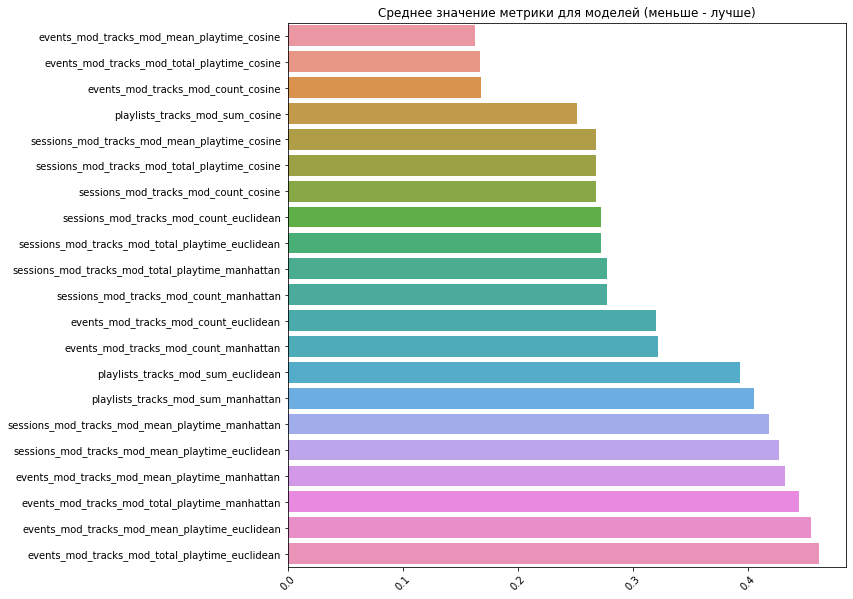

In [52]:
_ = plt.figure(figsize = (10, 10))
_ = sns.barplot(y = mean_results.index, x = mean_results.values)
_ = plt.xticks(rotation='45')
_ = plt.title('Среднее значение метрики для моделей (меньше - лучше)')

Как видно, на данной задаче лучше всего себя показала модель, рассчитывающая схожесть с помощью косинусного расстояния на основе информации о прослушиваниях треков различных исполнителей различными пользователями

В целом на большинстве векторных представлений лучший результат показывала метрика расстояния - косинусная близость. Это связано с тем, что в данной задаче скорее важны соотношения между количеством треков в плейлисте/сессии/у пользователя разных исполнителей, а не их абсолютное значение. Косинусное расстояние между, например, точкой (1, 1) и (10, 10) равно нулю, в то время как евклидова метрика и расстояние манхэттена в данном случае отличны от нуля.

Метрики близости, рассчитанные на основе данных о прослушиваниях пользователями треков исполнителей показала лучшие результаты, потому что данное векторное представление наилучшим образом предпочтения пользователей.

Важное дополнение: на одном из этапов работы результаты работы моделей отценивались как среднее место прослушанных треков в ранжированном списке, однако это приводило к неправильной трактовке резултатов: модель основанная на данных о плейлистах давала слишком хорошие результаты, эжто происходило потому, что в данных о плейлистах содержится информация о треках всего 33705 уникальных исполнителей, в то время как в данных о сессиях и прослушиваниях содержатся треки 401415 и 347523 исполнителей соотвественно. Скорее всего исполнители, треки которых есть в плейлистах, в целом являются более актуальными и популярными, что также сказывалось на результатах модели, однако эти результаты не показывали реальной точности модели.

In [53]:
event_data = pd.read_csv('events_modified.csv')
track_data = pd.read_csv('tracks_modified.csv')
session_data = pd.read_csv('sessions_modified.csv')
playlist_data = pd.read_csv('playlists.csv')

C:\Users\Sibmice\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
print('Количество уникальных исполнителей в плейлистах: ', len(pd.merge(playlist_data, track_data, on = 'track_id', how = 'inner')['artist_id'].unique()))
print('Количество уникальных исполнителей в списке прослушиваний: ', len(pd.merge(event_data, track_data, on = 'track_id', how = 'inner')['artist_id'].unique()))
print('Количество уникальных исполнителей в сессиях: ', len(pd.merge(session_data, track_data, on = 'track_id', how = 'inner')['artist_id'].unique()))

Количество уникальных исполнителей в плейлистах:  33705
Количество уникальных исполнителей в списке прослушиваний:  347523
Количество уникальных исполнителей в сессиях:  401415


## Проверка статистической значимости

Проверим статистическую значимость полученных результатов

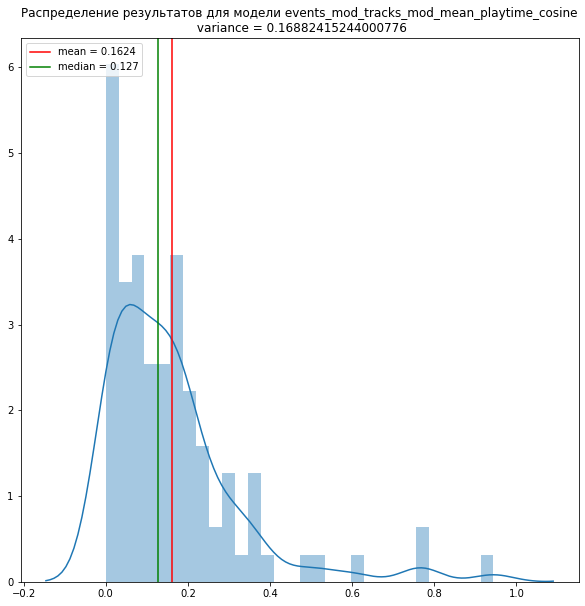

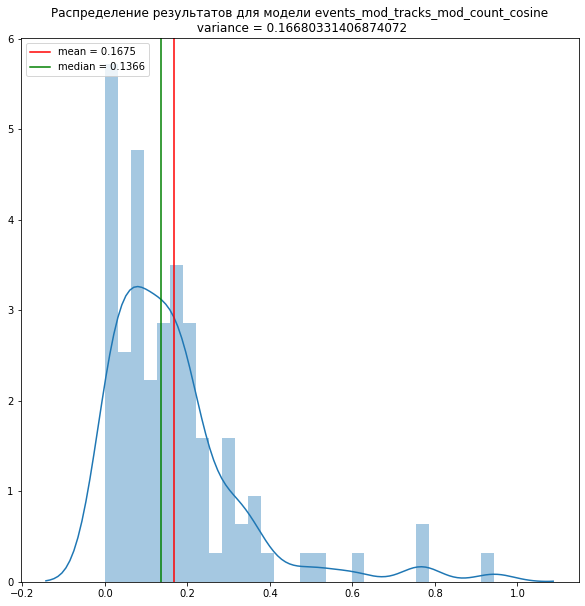

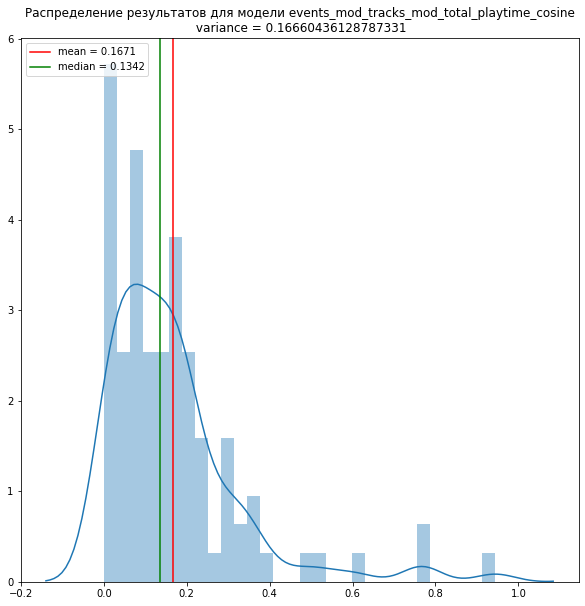

In [55]:
data = results['events_mod_tracks_mod_mean_playtime_cosine']['scores'].values
plt.figure(figsize = (10,10))
_ = sns.distplot(data, bins = 30)
_ = plt.axvline(np.nanmean(data), color = 'red', label = 'mean = {}'.format(round(np.nanmean(data), 4)))
_ = plt.axvline(np.nanmedian(data), color = 'green', label = 'median = {}'.format(round(np.nanmedian(data), 4)))
_ = plt.legend(loc="upper left")
_ = plt.title('Распределение результатов для модели events_mod_tracks_mod_mean_playtime_cosine\n variance = {}'.format(np.nanstd(data)))


data = results['events_mod_tracks_mod_count_cosine']['scores'].values
plt.figure(figsize = (10,10))
_ = sns.distplot(data, bins = 30)
_ = plt.axvline(np.nanmean(data), color = 'red', label = 'mean = {}'.format(round(np.nanmean(data), 4)))
_ = plt.axvline(np.nanmedian(data), color = 'green', label = 'median = {}'.format(round(np.nanmedian(data), 4)))
_ = plt.legend(loc="upper left")
_ = plt.title('Распределение результатов для модели events_mod_tracks_mod_count_cosine\n variance = {}'.format(np.nanstd(data)))


data = results['events_mod_tracks_mod_total_playtime_cosine']['scores'].values
plt.figure(figsize = (10,10))
_ = sns.distplot(data, bins = 30)
_ = plt.axvline(np.nanmean(data), color = 'red', label = 'mean = {}'.format(round(np.nanmean(data), 4)))
_ = plt.axvline(np.nanmedian(data), color = 'green', label = 'median = {}'.format(round(np.nanmedian(data), 4)))
_ = plt.legend(loc="upper left")
_ = plt.title('Распределение результатов для модели events_mod_tracks_mod_total_playtime_cosine\n variance = {}'.format(np.nanstd(data)))

Распределения не являются нормальными, так что при оценке статистчиеской значимости будем использовать непараметррические тесты

Проверим, являются ли различия в результатах моделей статистически значимыми

In [56]:
results_scores = results[['events_mod_tracks_mod_mean_playtime_cosine', 'events_mod_tracks_mod_count_cosine', 'events_mod_tracks_mod_total_playtime_cosine']].xs('scores', level=1, drop_level=False, axis = 1).droplevel(1, axis = 1)

In [57]:
p_value_frame = pd.DataFrame(index = results_scores.columns, columns = results_scores.columns, dtype = int)

In [58]:
for column1 in results_scores:
    for column2 in results_scores:
        p_value = stats.mannwhitneyu(results_scores[column1], 
                                     results_scores[column2], 
                                     alternative = 'two-sided')
        p_value_frame.loc[column1, column2] = p_value[1]
        p_value_frame.loc[column2, column1] = p_value[1]

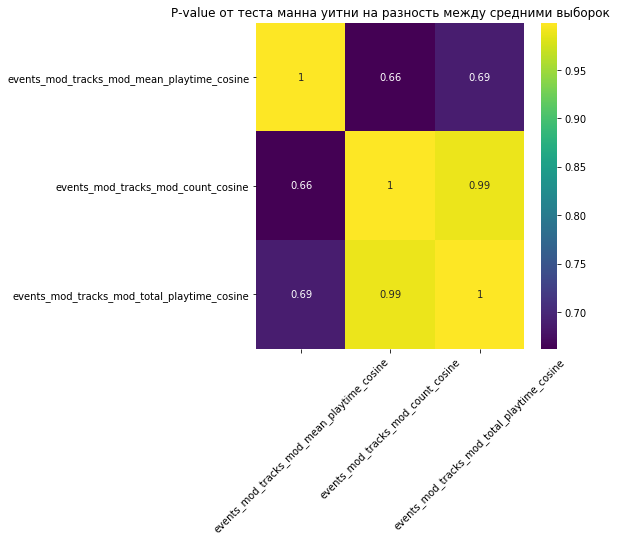

In [59]:
_ = plt.figure(figsize = (6, 6))
_ = sns.heatmap(p_value_frame, annot=True, cmap='viridis')
_ = plt.xticks(rotation = 45)
_ = plt.title('P-value от теста манна уитни на разность между средними выборок')

Таким образом, модели на основе данных о прослушиваниях треков с использованием косинусной метрики близости дают статистически незначимо различные результаты

Также проверим статистическую значимость различия результатов baseline модели и лучшей advanced модели

In [60]:
baseline_results = pd.read_csv('baseline_results.csv')

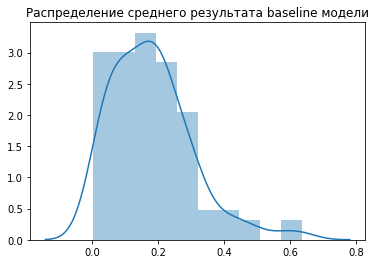

In [61]:
_ = plt.title('Распределение среднего результата baseline модели')
_ = sns.distplot(baseline_results['baseline_results'].values)

In [62]:
stats.mannwhitneyu(baseline_results['baseline_results'].values,
                   results_scores['events_mod_tracks_mod_mean_playtime_cosine'].values,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=5874.0, pvalue=0.03281782264617279)

P-value = 0.03, таким образом различие в средних значениях резулльтатов baseline и advanced моделей является статистически значимым, т.к. вероятность получить более крайние значения статистики = 0.03

Итого, лучшая модель - подсчет схожести исполнителей на основе данных о прослушанных пользователями исполнителей с помощью косинусной близости. При этом средний результат составил ~0.16, что на 0.34 лучше, чем у модели, рандомно ранжирующей исполнителей, и на ~0.02 лучше, чем у baseline модели. Также важное отличие от baseline модели заключается в том, что baseline модель хорошо ранжирует исполнителей, но показывает такие хорошие результаты лишь потому, что у самых популярных исполнителей (то есть тех, которых слушает множество пользователей) много треков, соотвественно они оказываются близки в верху ранжируемого списка, одна такое ранжирование имеет мало отношения к схожести между исполнителями.

## Результаты: кратко

Лучшая модель - подсчет схожести исполнителей на основе данных о прослушанных пользователями исполнителей с помощью косинусной близости. При этом средний результат составил ~0.16.
Векторное представление: вектор числа прослушиваний/среднего вемени прослушивания/общего вемени прослушивания (результаты этих моделей рразличаются статистически незначимо) пользователями треков каждого отдельного исполнителя

# Примеры похожих исполнителей

In [63]:
event_data = pd.read_csv('events_modified.csv')
track_data = pd.read_csv('tracks_modified.csv')
person_data = pd.read_csv('persons.csv')

C:\Users\Sibmice\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
all_data = count_agg(event_data, track_data, 'user_id', 'event_id', 'count')
all_data = add_idx(all_data, 'user_id')
all_matrix = creating_matrix(all_data, 'user_id_matrix', 'stat')

Выберем 3 исполнителей с id: 443804, 55302, 356929

In [65]:
print(person_data[person_data['person_id'] == 443804]['artist_name'].values[0])
print(person_data[person_data['person_id'] == 55302]['artist_name'].values[0])
print(person_data[person_data['person_id'] == 356929]['artist_name'].values[0])

Irma+&+The+Fascinations
Bongripper
The+Funky+Lowlives


In [66]:
exmpl_artists = [11893, 15230, 24590]

In [67]:
artist_similarity1 = pairwise_distances(all_matrix, all_matrix[exmpl_artists[0], :], metric = 'cosine')

In [68]:
top_20_1 = np.argsort(np.concatenate(artist_similarity1))[:20]

In [69]:
top_20_1 = all_data[all_data['artist_id_matrix'].isin(top_20_1)]['artist_id'].unique()

Таким образом, самые похожие исполнители на исполнителя Irma and The Fascinations:

In [70]:
person_data[person_data['person_id'].isin(top_20_1)]['artist_name'].reset_index(drop = True)

0                                         Osmany+Garcia
1                                   Gebr%C3%BCder+Grimm
2                                              Tanzilit
3                            Tiesto+Feat.+Priscilla+Ahn
4                               Irma+&+The+Fascinations
5                                          Wellness+Pur
6                                   Dark+Circle+Knights
7                            Marco+Von+M%C3%BCnchhausen
8                                            West+Sound
9                                       SUPERNIGHTMOVES
10                                          irma+&+Illl
11                                                  NTS
12                                                 Irma
13         Wyclef+Jean+Featuring+John+Fort%C3%A9+&+Pras
14                                      Kurt+Tepperwein
15                     Flux+Fiddlers%2FPlastic+Ono+Band
16                                                Thors
17                      Melanie+Charles+and+The+

In [71]:
artist_similarity2 = pairwise_distances(all_matrix, all_matrix[exmpl_artists[1], :], metric = 'cosine')

In [72]:
top_20_2 = np.argsort(np.concatenate(artist_similarity2))[:20]

In [73]:
top_20_2 = all_data[all_data['artist_id_matrix'].isin(top_20_2)]['artist_id'].unique()

Самые похожие исполнители на исполнителя Bongripper

In [74]:
person_data[person_data['person_id'].isin(top_20_2)]['artist_name'].reset_index(drop = True)

0             Masters+At+Work+feat+Luis+Salinas
1                              Lars+M%C3%B6ller
2                            Kristian+Jorgensen
3                       The+Tom+Warrington+Trio
4                           Dave+Holland+Sextet
5            John+Fumasoli+and+the+Jones+Factor
6                            The+Funky+Lowlives
7                          The+Clayton+Brothers
8                  Chick+Corea,+John+McLaughlin
9                                    Greg+Skaff
10              Hadley+Caliman,+Pete+Christlieb
11                                 Chris+Massey
12                               Kenny+Drew+Jr.
13                  Chick+Corea,+Bobby+McFerrin
14                              Guillermo+Klein
15                             The+Wrong+Humans
16    Larry+Coryell,+Victor+Bailey,+Lenny+White
17                                 Ken+Battista
18        Chick+Corea,+Eddie+Gomez,+Paul+Motian
19               Hiroshima+(ft+Paul+Hardcastle)
Name: artist_name, dtype: object

In [75]:
artist_similarity3 = pairwise_distances(all_matrix, all_matrix[exmpl_artists[2], :], metric = 'cosine')

In [76]:
top_20_3 = np.argsort(np.concatenate(artist_similarity3))[:20]

In [77]:
top_20_3 = all_data[all_data['artist_id_matrix'].isin(top_20_3)]['artist_id'].unique()

Самые похожие исполнители на исполнителя The Funky Lowlives

In [78]:
person_data[person_data['person_id'].isin(top_20_3)]['artist_name'].reset_index(drop = True)

0                                   Call+The+Mothership
1                                           FIRST+LOOK!
2                        Joe+Acheson+(Hidden+Orchestra)
3                                      Alize+Coco+Peach
4                                        Walls+Fall+Out
5                              BREAKING+BAD+GLASS+CANDY
6                        Hidden+Orchestra+(Joe+Acheson)
7     %E3%82%B9%E3%83%BC%E3%83%91%E3%83%BC%E3%82%BB%...
8     cyberlust+X+peazy86%E3%82%B5%E3%82%A4%E3%83%90...
9                          5ips1s+(Narcosis+And+Cymazz)
10                                           Bongripper
11                                             finished
12                                          DarkEntries
13    Das+Ende+von+Nintendo%3F+Plus:+Spiele-Geheimtipps
14                     Dubstep+Killed+Rock+%27n%27+Roll
15       %E3%83%9E%E3%82%AF%E3%83%AD%E3%82%B9MACROSS+82
16                                        Jagged+Vision
17                        Bongripper+&+Winters+I